# imports

In [1]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/MyDrive/PHYS6060/ML_strategy/')

!pip install wandb

from data import Data
from ML_Models import *

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
path = "/content/gdrive/MyDrive/PHYS6060/ML_strategy/"

# data processing

## load historical data

In [3]:
import datetime

In [75]:
ticker = 'SPY'
start = datetime.datetime(1994,1,25)
end = datetime.datetime(2002,1,1)

data = Data(tickers=[ticker], start=start, end=end, interval='1d')
# data = Data(tickers=[ticker], max=True, interval='1d')

# build design matrix and set target
FEATURES, TARGET = data.feature_matrix(ticker, target='binary', leak=False, scale=True)

# PCA dimension reduction
FEATURES = data.pca_reduction(FEATURES, k=10)

# drop redundant features
# FEATURES=FEATURES.drop(['Open', 'High', 'Low', 'Close','Volume_ratio_week',
#        'Adj_close_ratio_month', 'Volume_ratio_month',
#        'Adj_close_ratio_quarter', 'Volume_ratio_quarter',
#        'Adj_close_ratio_year', 'Volume_ratio_year', 'Adj_close_first_diff',
#        'Volume_first_diff', 'Adj_close_second_diff', 'Volume_second_diff',
#         'pct_lag_week', 'pct_lag_quarter', 'pct_lag_year',
#        'Adj_lag_week', 'Adj_lag_quarter', 'Adj_lag_year', 'Vol_lag_week',
#        'Vol_lag_quarter', 'Vol_lag_year'], axis=1)

# input shape for features
num_features = FEATURES.columns.shape[0]
input_shape = (1, num_features)

# show features
print(FEATURES.columns)
print(input_shape)

[*********************100%%**********************]  1 of 1 completed
Index(['col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8',
       'col_9', 'col_10'],
      dtype='object')
(1, 10)


In [ ]:
data.quick_view()

## train, validation, test split

In [76]:
# data held out to test on
predict_days = 30
FEATURES, TARGET, X_test, Y_test = held_out(FEATURES, TARGET, test_size=predict_days)

# validation split
training_data = val_split(FEATURES, TARGET, test_size=0.20, shuffle=False)
X_train, Y_train, X_val, Y_val = training_data['X_train'],  training_data['Y_train'],  training_data['X_val'],  training_data['Y_val']

In [77]:
len(X_val)

344

# Models

## XGBoost regression

In [22]:
## XGBoost Regression
xgb_params = {
    'learning_rate': 0.01,
    'n_estimators':2500,
    'batch_size': 12,
    'optimizer':'gbtree',
    'wandb': False,
    'save': False,
    'name': 'XBG_SPY_REG',
    'run': 'run_01',
    'entity': 'asorliklab',
    'dataset': 'SPY',
    'model_architecture': 'Gradient Boosting',
    'objective':'regression',
    'epochs':10,
    'test_split':30,
    'validation_split':0.2
}

In [23]:
xgb_model = Regression_XGBoost(**xgb_params)

In [24]:
xgb_model.train(X_train, Y_train, X_val, Y_val)

[0]	validation_0-rmse:1.50163	validation_0-mae:0.80295	validation_1-rmse:0.89084	validation_1-mae:0.72118
[100]	validation_0-rmse:0.88985	validation_0-mae:0.48478	validation_1-rmse:0.57675	validation_1-mae:0.46726
[200]	validation_0-rmse:0.62464	validation_0-mae:0.39332	validation_1-rmse:0.52803	validation_1-mae:0.42553
[300]	validation_0-rmse:0.49704	validation_0-mae:0.35045	validation_1-rmse:0.52157	validation_1-mae:0.42143
[400]	validation_0-rmse:0.43012	validation_0-mae:0.32270	validation_1-rmse:0.52790	validation_1-mae:0.42506
[500]	validation_0-rmse:0.39194	validation_0-mae:0.30201	validation_1-rmse:0.52775	validation_1-mae:0.42302
[600]	validation_0-rmse:0.36866	validation_0-mae:0.28656	validation_1-rmse:0.52853	validation_1-mae:0.42353
[700]	validation_0-rmse:0.34908	validation_0-mae:0.27213	validation_1-rmse:0.52791	validation_1-mae:0.42322
[800]	validation_0-rmse:0.32872	validation_0-mae:0.25536	validation_1-rmse:0.52774	validation_1-mae:0.42345
[900]	validation_0-rmse:0.3068

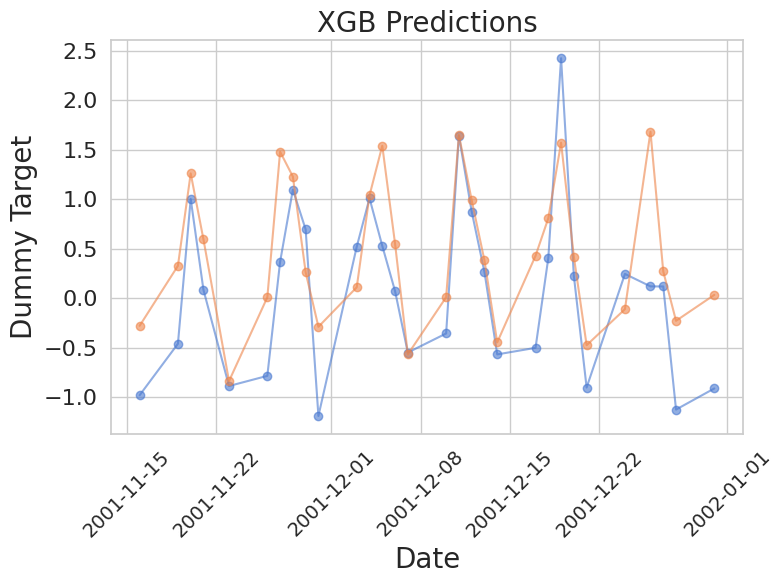

In [26]:
pred = xgb_model.predict(X_test, Y_test)['predictions']
growth_factors_actual = 1 + Y_test
growth_factors_pred = 1 + pred

# Calculate cumulative product to see compounded growth
cumulative_growth_actual = growth_factors_actual.cumprod()
cumulative_growth_pred = growth_factors_pred.cumprod()

# Plot the results
plt.figure(figsize=(8, 6))
# plt.plot(cumulative_growth_actual.index, cumulative_growth_actual, label='Actual Cumulative Growth', marker='o', alpha=0.6)
# plt.plot(cumulative_growth_actual.index, cumulative_growth_pred, label='Predicted Cumulative Growth', marker='o', alpha=0.6)
plt.plot(Y_test.index, Y_test, label='Actual Cumulative Growth', marker='o', alpha=0.6)
plt.plot(Y_test.index, pred, label='Predicted Cumulative Growth', marker='o', alpha=0.6)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Dummy Target', fontsize=20)
plt.title('XGB Predictions', fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=16)
# plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(path+"plots/project/"+"XGB_regression_dummy.pdf")
plt.show()

In [116]:
pred_test.index[0]

Timestamp('2023-02-14 00:00:00')

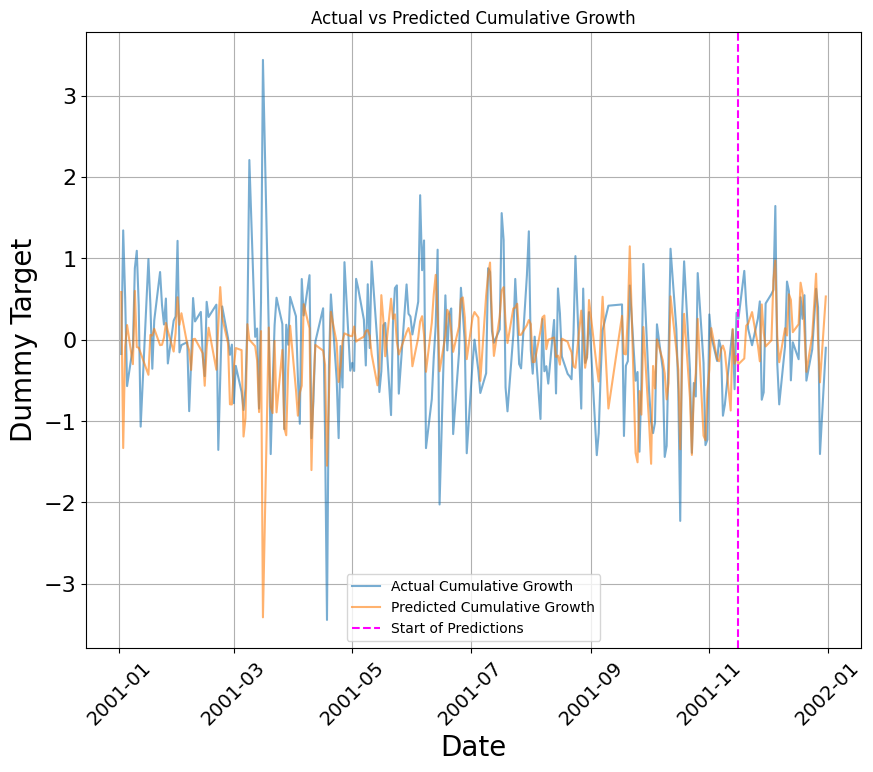

In [31]:
pred_train = xgb_model.predict(X_train, Y_train)['predictions']

pred_val = xgb_model.predict(X_val, Y_val)['predictions']

# test data
pred_test = xgb_model.predict(X_test, Y_test)['predictions']
x_preds = pred_test.index[0]

# # combine lists
combined_actual =  pd.concat([Y_train, Y_val, Y_test], ignore_index=False)
combined_pred =  pd.concat([pred_train, pred_val, pred_test], ignore_index=False)

# growth_factors_actual = 1 + combined_actual
# growth_factors_pred = 1 + combined_pred

# # Calculate cumulative product to see compounded growth
# cumulative_growth_actual = growth_factors_actual.cumprod()
# cumulative_growth_pred = growth_factors_pred.cumprod()

cut = "2001-01-01"

# Plot the results
plt.figure(figsize=(10, 8))
plt.plot(combined_actual["2001-01-01":].index, combined_actual["2001-01-01":], label='Actual Cumulative Growth', marker='o', ms=0.01, alpha=0.6)
plt.plot(combined_actual["2001-01-01":].index, combined_pred["2001-01-01":], label='Predicted Cumulative Growth', marker='o', ms=0.01, alpha=0.6)
plt.axvline(x=x_preds, color='magenta', linestyle='--', label='Start of Predictions')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Dummy Target', fontsize=20)
plt.title('Actual vs Predicted Cumulative Growth')
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

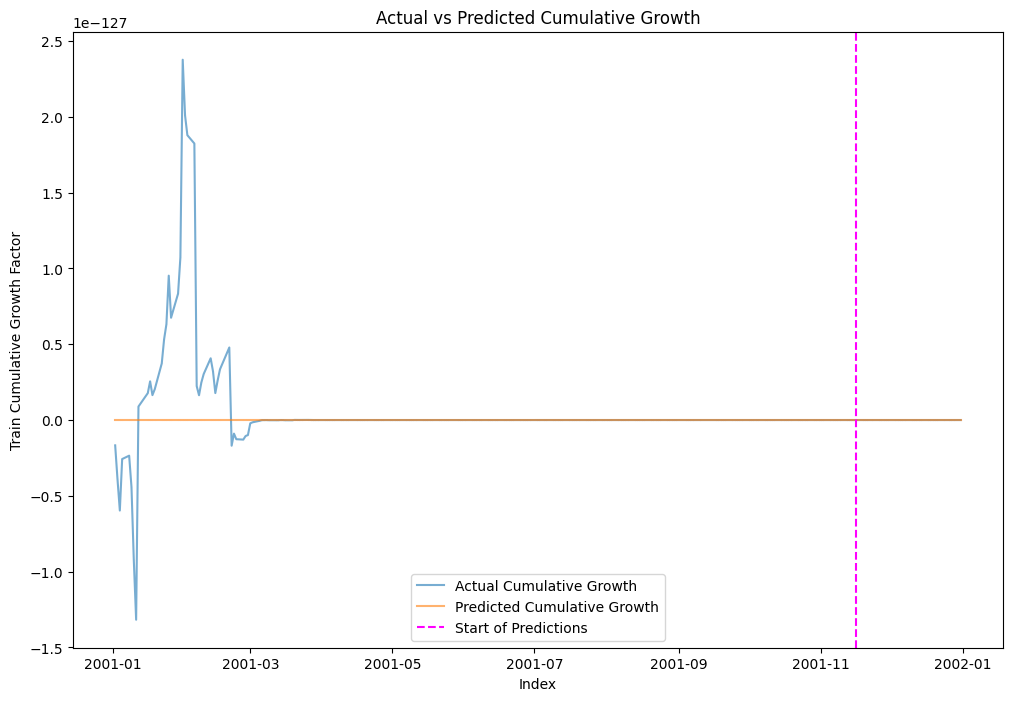

In [27]:
pred_train = xgb_model.predict(X_train, Y_train)['predictions']

pred_val = xgb_model.predict(X_val, Y_val)['predictions']

# test data
pred_test = xgb_model.predict(X_test, Y_test)['predictions']
x_preds = pred_test.index[0]

# combine lists
combined_actual =  pd.concat([Y_train, Y_val, Y_test], ignore_index=False)
combined_pred =  pd.concat([pred_train, pred_val, pred_test], ignore_index=False)

growth_factors_actual = 1 + combined_actual
growth_factors_pred = 1 + combined_pred

# Calculate cumulative product to see compounded growth
cumulative_growth_actual = growth_factors_actual.cumprod()
cumulative_growth_pred = growth_factors_pred.cumprod()

cut = "2001-01-01"

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(combined_actual["2001-01-01":].index, cumulative_growth_actual["2001-01-01":], label='Actual Cumulative Growth', marker='o', ms=0.01, alpha=0.6)
plt.plot(combined_actual["2001-01-01":].index, cumulative_growth_pred["2001-01-01":], label='Predicted Cumulative Growth', marker='o', ms=0.01, alpha=0.6)
plt.axvline(x=x_preds, color='magenta', linestyle='--', label='Start of Predictions')
plt.xlabel('Index')
plt.ylabel('Train Cumulative Growth Factor')
plt.title('Actual vs Predicted Cumulative Growth')
plt.legend()
plt.show()


In [77]:
cumulative_growth_actual[:"2001-01-01"]

Date
1995-01-23    1.001338
1995-01-24    1.004016
1995-01-25    1.005020
1995-01-26    1.009036
1995-01-27    1.004685
                ...   
2000-12-22    3.107475
2000-12-26    3.130222
2000-12-27    3.139762
2000-12-28    3.080327
2000-12-29    3.024560
Name: TARGET, Length: 1501, dtype: float64

In [121]:
FEATURES.index[0]

Timestamp('1994-01-25 00:00:00')

In [105]:
|type(growth_factors_actual)

pandas.core.series.Series

## XGBoost

In [67]:
xgb_params = {
    'learning_rate': 0.001,
    'n_estimators':3000,
    'batch_size': 32,
    'optimizer':'gbtree',
    'wandb': True,
    'save': False,
    'name': 'XBG_SPY',
    'run': 'run_01',
    'entity': 'asorliklab',
    'dataset': 'MSFT',
    'model_architecture': 'Gradient Boosting',
    'objective':'binary classification',
    'epochs':10,
    'test_split':30,
    'validation_split':0.2
}

In [68]:
xgb_model = Binary_XGBoost(**xgb_params)

In [69]:
xgb_model.train(X_train, Y_train, X_val, Y_val)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


[0]	validation_0-logloss:0.69156	validation_0-error:0.47286	validation_1-logloss:0.69389	validation_1-error:0.49412
[100]	validation_0-logloss:0.68147	validation_0-error:0.44042	validation_1-logloss:0.68805	validation_1-error:0.49412
[200]	validation_0-logloss:0.67229	validation_0-error:0.41422	validation_1-logloss:0.68484	validation_1-error:0.48235
[300]	validation_0-logloss:0.66433	validation_0-error:0.38615	validation_1-logloss:0.68243	validation_1-error:0.47059
[400]	validation_0-logloss:0.65654	validation_0-error:0.35621	validation_1-logloss:0.68102	validation_1-error:0.45882
[500]	validation_0-logloss:0.64824	validation_0-error:0.32127	validation_1-logloss:0.68304	validation_1-error:0.47059
[600]	validation_0-logloss:0.64057	validation_0-error:0.29757	validation_1-logloss:0.68714	validation_1-error:0.48235
[700]	validation_0-logloss:0.63348	validation_0-error:0.28260	validation_1-logloss:0.69147	validation_1-error:0.48235
[800]	validation_0-logloss:0.62637	validation_0-error:0.25

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_0-error,█▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
validation_0-logloss,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
validation_1-error,██▆▃▃▁▃▆▆▆▆█████████████████████████████
validation_1-logloss,▃▂▂▁▁▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇█▇▇█████████
epoch,2999


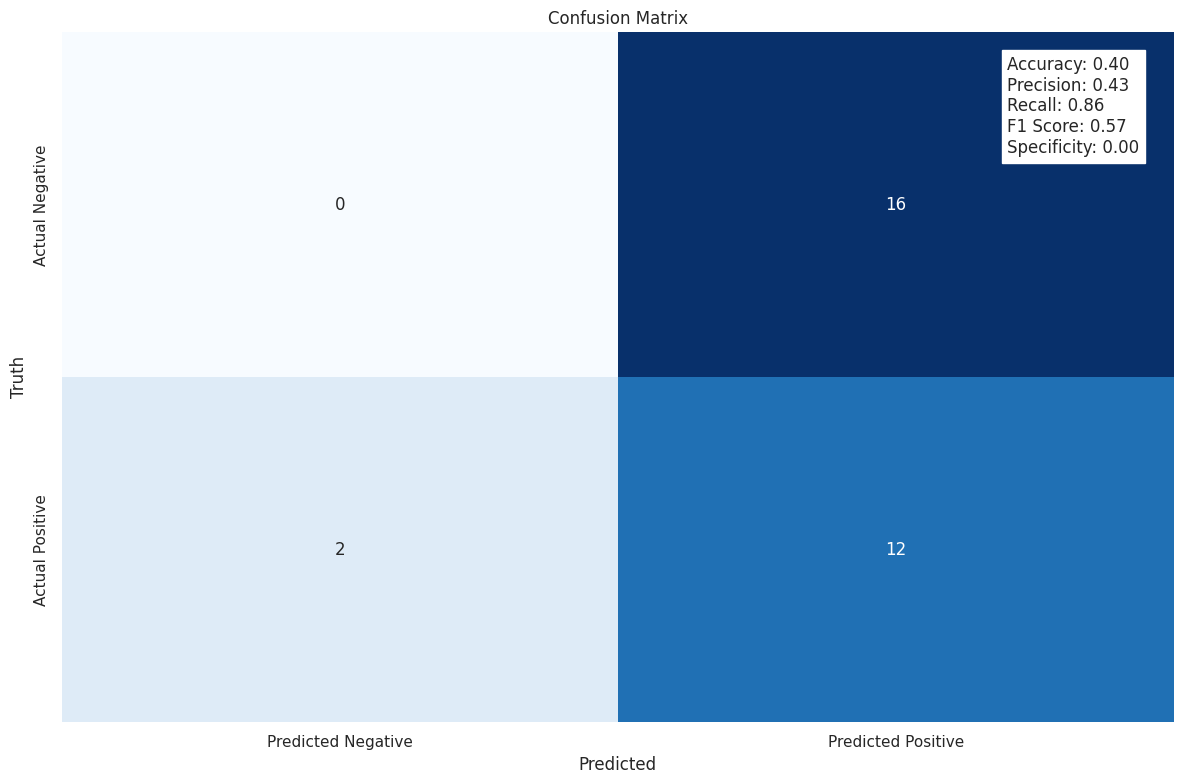

In [70]:
pred = xgb_model.predict(X_test, Y_test)['predictions']
error_matrix(Y_test, pred)

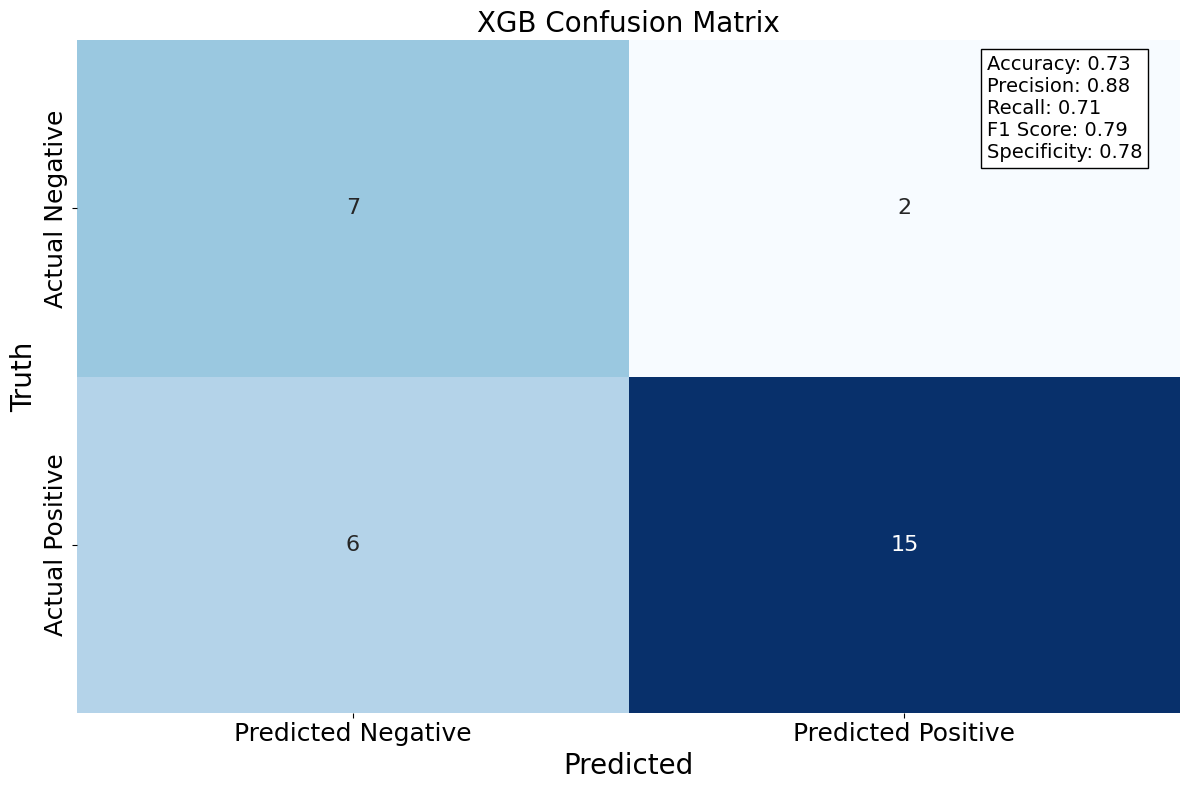

In [12]:
pred = xgb_model.predict(X_test, Y_test)['predictions']
conf_matrix = confusion_matrix(Y_test, pred)
errors = error_metrics(Y_test, pred)
accuracy = errors['accuracy']
precision = errors['precision']
recall = errors['recall']
f1 = errors['f1']
specificity = errors['specificity']


plt.figure(figsize=(12, 8))
heatmap=sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            annot_kws={"size": 16})

heatmap.set_xticklabels(heatmap.get_xticklabels(), size=18)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=18)

metrics_text = f'Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}\nSpecificity: {specificity:.2f}'
plt.text(1.65, 0.35, metrics_text, fontsize=14, bbox=dict(facecolor='white', alpha=1))

plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Truth', fontsize=20)
plt.title('XGB Confusion Matrix', fontsize=20)

plt.tight_layout()
plt.savefig(path+"plots/project/"+"XGB_confusion_dummy.pdf")
plt.show()

In [145]:
random_array = np.random.randint(2, size=30)  # Adjust the size as needed

random_list = random_array.tolist()  # Convert the NumPy array to a Python list

print(random_list)

[0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1]


In [146]:
(Y_test == random_list).astype(int).sum() /30

0.5666666666666667

In [147]:
pred

Date
2001-11-15    1
2001-11-16    1
2001-11-19    1
2001-11-20    1
2001-11-21    1
2001-11-23    1
2001-11-26    1
2001-11-27    1
2001-11-28    1
2001-11-29    1
2001-11-30    1
2001-12-03    1
2001-12-04    1
2001-12-05    1
2001-12-06    1
2001-12-07    1
2001-12-10    1
2001-12-11    0
2001-12-12    0
2001-12-13    1
2001-12-14    1
2001-12-17    0
2001-12-18    0
2001-12-19    0
2001-12-20    1
2001-12-21    0
2001-12-24    0
2001-12-26    0
2001-12-27    1
2001-12-28    1
dtype: int64

## LSTM Regression

In [27]:
lstm_params = {
    'learning_rate': 0.01,
    'epochs': 20,
    'batch_size': 32,
    'lstm_units': 10,
    'dense_units': 16,
    'dropout_rate': 0.0,
    'optimizer': 'Adam',
    'wandb': False,
    'save': False,
    'name': 'LSTM_SPY_REG_LEAK',
    'run': 'run_01',
    'entity': 'asorliklab',
    'dataset': 'MSFT',
    'objective':'linear:regression',
    'input_shape':input_shape,
    'test_split':30,
    'validation_split':0.2,
    'model_architecture':'RNN'
}

In [28]:
lstm = Regression_LSTM(capacity='low', **lstm_params)

In [29]:
history = lstm.train(X_train, Y_train, X_val, Y_val)

Epoch 1/20
43/43 [==============================] - 3s 16ms/step - loss: 2.2125 - mae: 0.7903 - val_loss: 0.7221 - val_mae: 0.6906
Epoch 2/20
43/43 [==============================] - 0s 4ms/step - loss: 2.1094 - mae: 0.7647 - val_loss: 0.6880 - val_mae: 0.6671
Epoch 3/20
43/43 [==============================] - 0s 7ms/step - loss: 2.0329 - mae: 0.7486 - val_loss: 0.7012 - val_mae: 0.6802
Epoch 4/20
43/43 [==============================] - 0s 4ms/step - loss: 2.0116 - mae: 0.7472 - val_loss: 0.6206 - val_mae: 0.6376
Epoch 5/20
43/43 [==============================] - 0s 3ms/step - loss: 1.9121 - mae: 0.7192 - val_loss: 0.5541 - val_mae: 0.5962
Epoch 6/20
43/43 [==============================] - 0s 4ms/step - loss: 1.8362 - mae: 0.7000 - val_loss: 0.6662 - val_mae: 0.6470
Epoch 7/20
43/43 [==============================] - 0s 3ms/step - loss: 1.8130 - mae: 0.6836 - val_loss: 0.6836 - val_mae: 0.6751
Epoch 8/20
43/43 [==============================] - 0s 4ms/step - loss: 1.7322 - mae: 0.6

1/1 [==============================] - 0s 22ms/step


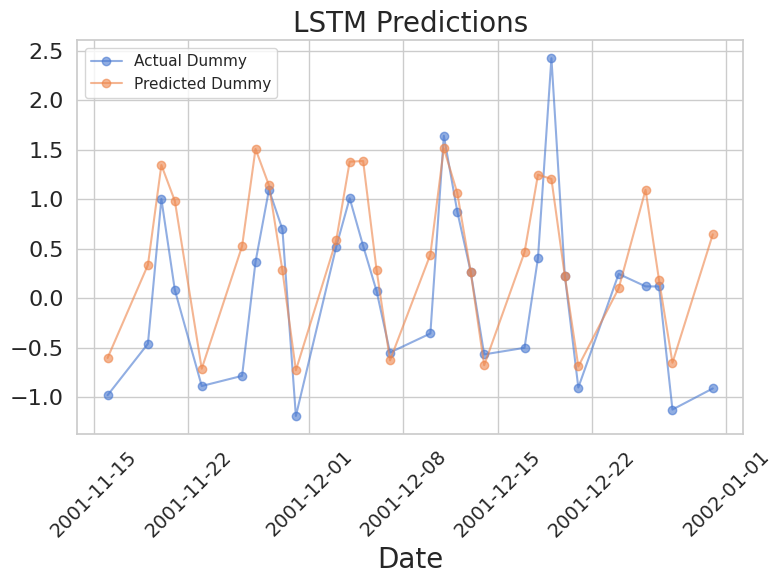

In [31]:
pred = lstm.predict(X_test, Y_test)['predictions']

growth_factors_actual = 1 + Y_test / 100
growth_factors_pred = 1 + pred / 100

# Calculate cumulative product to see compounded growth
cumulative_growth_actual = growth_factors_actual.cumprod()
cumulative_growth_pred = growth_factors_pred.cumprod()

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(Y_test.index, Y_test, label='Actual Dummy', marker='o', alpha=0.6)
plt.plot(Y_test.index, pred, label='Predicted Dummy', marker='o', alpha=0.6)
plt.xlabel('Date', fontsize=20)
# plt.ylabel('Cumulative Growth Factor')
plt.title('LSTM Predictions', fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(path+"plots/project/"+"LSTM_regression_dummy.pdf")
plt.show()

In [223]:
pred

Date
2001-10-04    0.002941
2001-10-05   -0.004441
2001-10-08   -0.009632
2001-10-09    0.021519
2001-10-10    0.015312
2001-10-11   -0.004808
2001-10-12   -0.000161
2001-10-15    0.001661
2001-10-16   -0.025461
2001-10-17   -0.004625
2001-10-18   -0.005476
2001-10-19    0.014081
2001-10-22   -0.011054
2001-10-23   -0.007691
2001-10-24    0.013824
2001-10-25   -0.006408
2001-10-26   -0.027627
2001-10-29   -0.018299
2001-10-30   -0.011319
2001-10-31    0.020126
2001-11-01    0.000344
2001-11-02    0.008717
2001-11-05    0.010704
2001-11-06   -0.006450
2001-11-07   -0.002418
2001-11-08   -0.002404
2001-11-09   -0.010835
2001-11-12    0.015214
2001-11-13   -0.003596
2001-11-14   -0.001577
dtype: float32

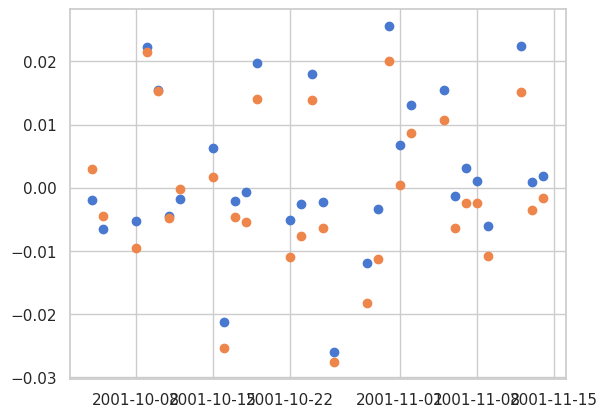

In [224]:
plt.scatter(Y_test.index, Y_test)
plt.scatter(Y_test.index, pred)

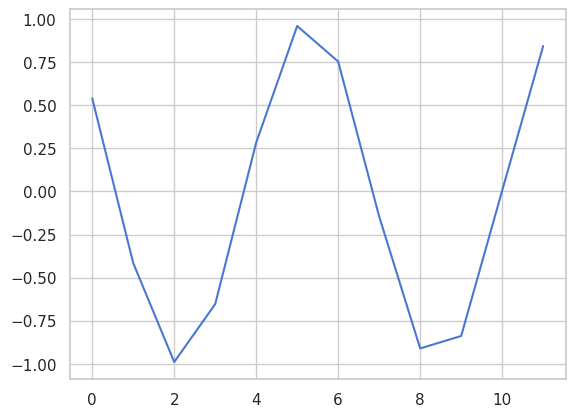

In [230]:
lst = np.linspace(1,12,12)
tst = np.cos(lst)
plt.plot(tst)

(array([3., 1., 4., 5., 0., 7., 2., 5., 1., 2.]),
 array([0.02379553, 0.02779078, 0.03178603, 0.03578128, 0.03977653,
        0.04377177, 0.04776702, 0.05176227, 0.05575752, 0.05975277,
        0.06374802]),
 <BarContainer object of 10 artists>)

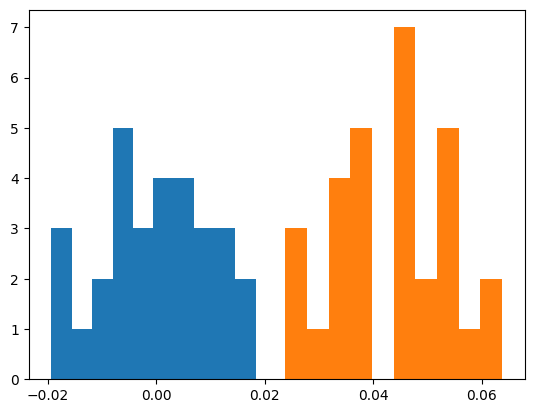

In [65]:
plt.hist(Y_test)
plt.hist(pred)

In [62]:
np.std(Y_test)

0.010349910307382016

11/11 [==============================] - 0s 2ms/step


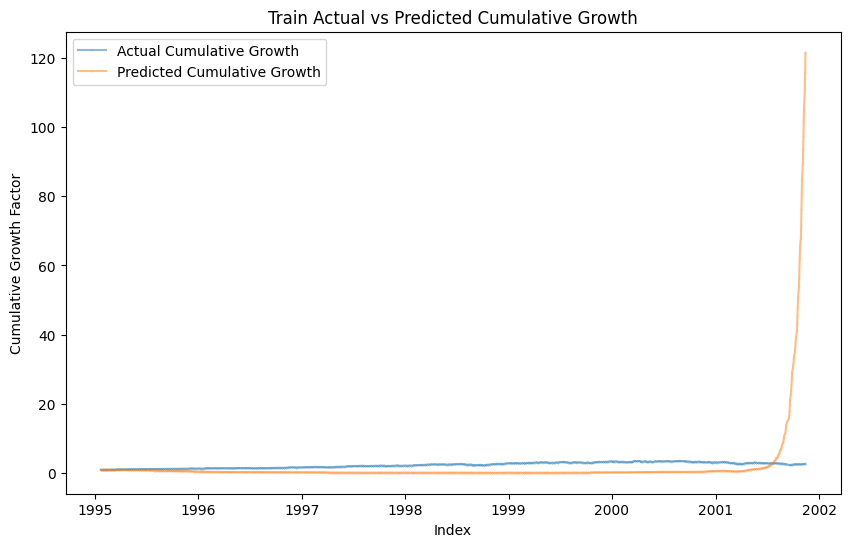

In [33]:
pred = lstm.predict(X_train, Y_train)['predictions']

pred_val = lstm.predict(X_val, Y_val)['predictions']

# combine lists
combined_actual =  pd.concat([Y_train, Y_val], ignore_index=False)
combined_pred =  pd.concat([pred_train, pred_val], ignore_index=False)

growth_factors_actual = 1 + combined_actual
growth_factors_pred = 1 + combined_pred

# Calculate cumulative product to see compounded growth
cumulative_growth_actual = growth_factors_actual.cumprod()
cumulative_growth_pred = growth_factors_pred.cumprod()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(cumulative_growth_actual.index, cumulative_growth_actual, label='Actual Cumulative Growth', marker='o', ms=0.1, alpha=0.5)
plt.plot(cumulative_growth_actual.index, cumulative_growth_pred, label='Predicted Cumulative Growth', marker='o',ms=0.1, alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Cumulative Growth Factor')
plt.title('Train Actual vs Predicted Cumulative Growth')
plt.legend()
plt.show()

1/1 [==============================] - 0s 22ms/step


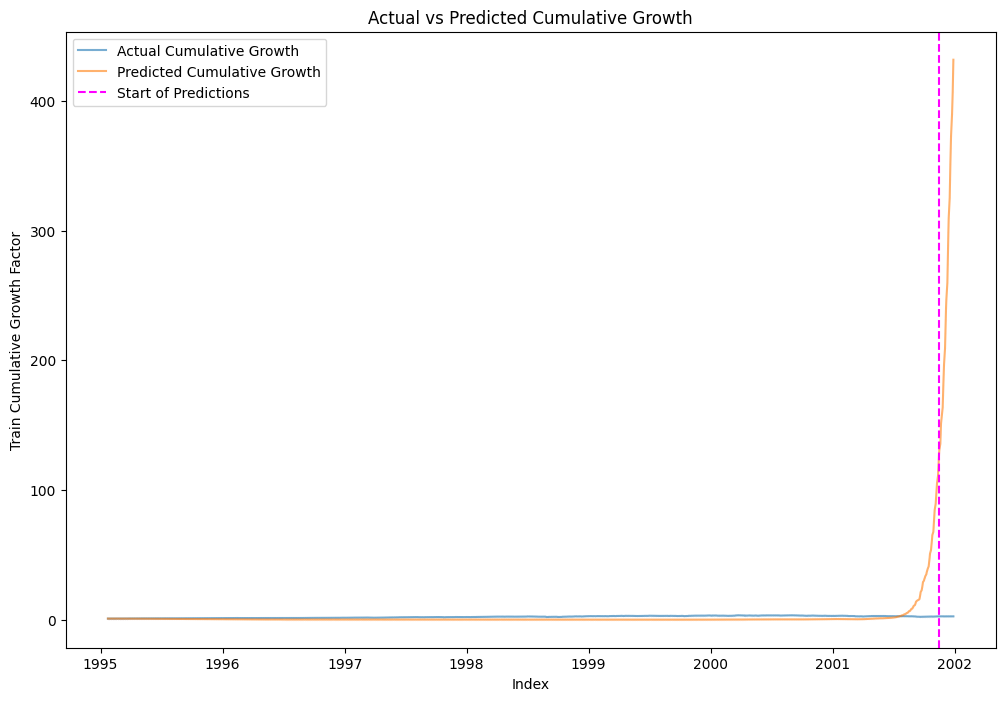

In [32]:
pred_train = lstm.predict(X_train, Y_train)['predictions']

pred_val = lstm.predict(X_val, Y_val)['predictions']

# test data
pred_test = lstm.predict(X_test, Y_test)['predictions']
x_preds = pred_test.index[0]

# combine lists
combined_actual =  pd.concat([Y_train, Y_val, Y_test], ignore_index=False)
combined_pred =  pd.concat([pred_train, pred_val, pred_test], ignore_index=False)

growth_factors_actual = 1 + combined_actual
growth_factors_pred = 1 + combined_pred

# Calculate cumulative product to see compounded growth
cumulative_growth_actual = growth_factors_actual.cumprod()
cumulative_growth_pred = growth_factors_pred.cumprod()

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(combined_actual.index, cumulative_growth_actual, label='Actual Cumulative Growth', marker='o', ms=0.01, alpha=0.6)
plt.plot(combined_actual.index, cumulative_growth_pred, label='Predicted Cumulative Growth', marker='o', ms=0.01, alpha=0.6)
plt.axvline(x=x_preds, color='magenta', linestyle='--', label='Start of Predictions')
plt.xlabel('Index')
plt.ylabel('Train Cumulative Growth Factor')
plt.title('Actual vs Predicted Cumulative Growth')
plt.legend()
plt.show()

52/52 [==============================] - 0s 2ms/step


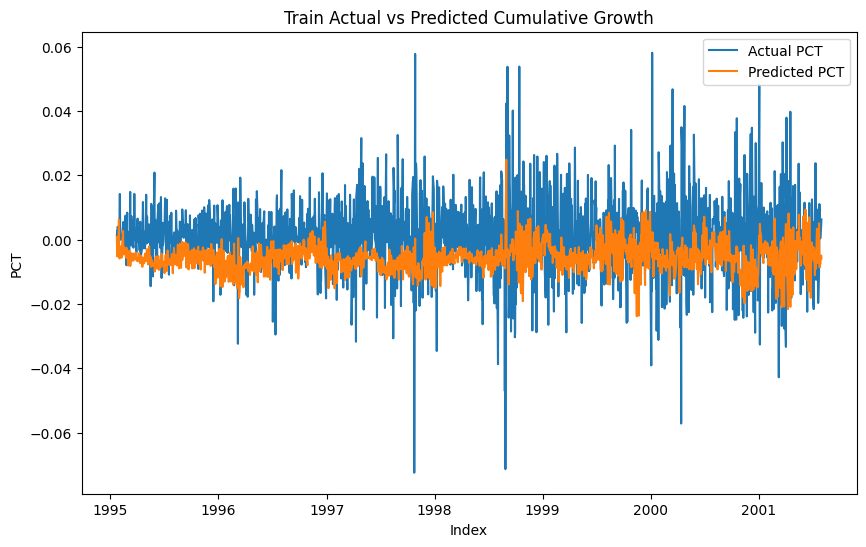

In [156]:
pred = lstm.predict(X_train, Y_train)['predictions']


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(Y_train.index, Y_train, label='Actual PCT')
plt.plot(Y_train.index, pred, label='Predicted PCT')
plt.xlabel('Index')
plt.ylabel('PCT')
plt.title('Train Actual vs Predicted Cumulative Growth')
plt.legend()
plt.show()

(array([  8.,  43., 230., 802., 437.,  99.,  27.,   0.,   0.,   1.]),
 array([-0.02383153, -0.01896656, -0.01410159, -0.00923662, -0.00437166,
         0.00049331,  0.00535828,  0.01022325,  0.01508822,  0.01995319,
         0.02481816]),
 <BarContainer object of 10 artists>)

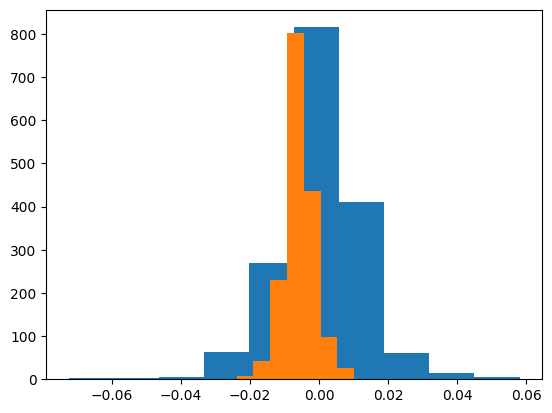

In [157]:
# fig, ax = plt.subplots(1,2,figsize=(14,8))

# ax[0].hist(Y_train)
plt.hist(Y_train)
plt.hist(pred)

4/4 [==============================] - 0s 4ms/step


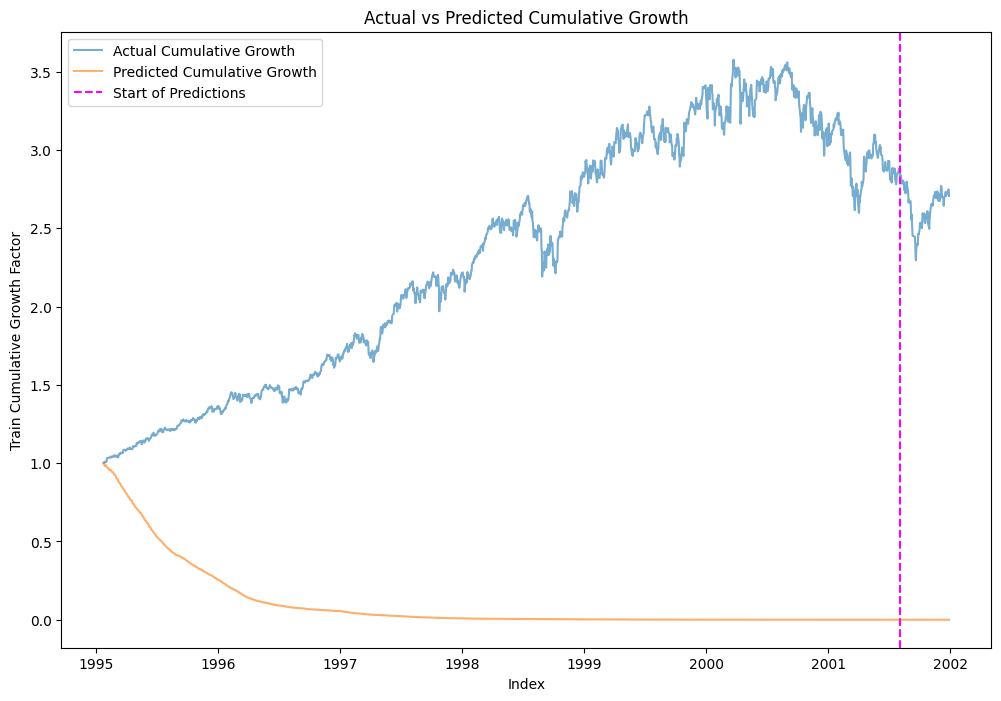

In [158]:
pred_train = lstm.predict(X_train, Y_train)['predictions']

# test data
pred_test = lstm.predict(X_test, Y_test)['predictions']
x_preds = pred_test.index[0]

# combine lists
combined_actual =  pd.concat([Y_train, Y_test], ignore_index=False)
combined_pred =  pd.concat([pred_train, pred_test], ignore_index=False)

growth_factors_actual = 1 + combined_actual
growth_factors_pred = 1 + combined_pred

# Calculate cumulative product to see compounded growth
cumulative_growth_actual = growth_factors_actual.cumprod()
cumulative_growth_pred = growth_factors_pred.cumprod()

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(combined_actual.index, cumulative_growth_actual, label='Actual Cumulative Growth', marker='o', ms=0.01, alpha=0.6)
plt.plot(combined_actual.index, cumulative_growth_pred, label='Predicted Cumulative Growth', marker='o', ms=0.01, alpha=0.6)
plt.axvline(x=x_preds, color='magenta', linestyle='--', label='Start of Predictions')
plt.xlabel('Index')
plt.ylabel('Train Cumulative Growth Factor')
plt.title('Actual vs Predicted Cumulative Growth')
plt.legend()
plt.show()

In [76]:
print("mean: ", np.mean(Y_train), ' std: ', np.std(Y_train))
print("mean: ", np.mean(pred), ' std: ', np.std(pred))

mean:  0.00044479545801240947  std:  0.011991436550902804
mean:  0.0031137678  std:  0.0026629656


## LSTM

In [129]:
lstm_params = {
    'learning_rate': 0.1,
    'epochs': 50,
    'batch_size': 32,
    'lstm_units': 10,
    'dense_units': 128,
    'dropout_rate': 0.0,
    'optimizer': 'Adam',
    'wandb': True,
    'save': False,
    'name': 'LSTM_SPY',
    'run': 'run_01',
    'entity': 'asorliklab',
    'dataset': 'MSFT',
    'objective':'linear:regression',
    'input_shape':input_shape,
    'test_split':30,
    'validation_split':0.2,
    'model_architecture':'RNN'
}

In [130]:
lstm = Binary_LSTM(capacity='medium', **lstm_params)

In [131]:
history = lstm.train(X_train, Y_train, X_val, Y_val)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/50
42/43 [============================>.] - ETA: 0s - loss: 0.6948 - accuracy: 0.5357

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231216_030249-moops91z/files/model-best)... Done. 0.0s


43/43 [==============================] - 15s 252ms/step - loss: 0.6950 - accuracy: 0.5342 - val_loss: 0.6950 - val_accuracy: 0.5058
Epoch 2/50
40/43 [==========================>...] - ETA: 0s - loss: 0.6944 - accuracy: 0.5180

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231216_030249-moops91z/files/model-best)... Done. 0.0s


43/43 [==============================] - 9s 206ms/step - loss: 0.6942 - accuracy: 0.5197 - val_loss: 0.6931 - val_accuracy: 0.5058
Epoch 3/50
43/43 [==============================] - 0s 6ms/step - loss: 0.6953 - accuracy: 0.5124 - val_loss: 0.6978 - val_accuracy: 0.5058
Epoch 4/50
43/43 [==============================] - 0s 8ms/step - loss: 0.6953 - accuracy: 0.5066 - val_loss: 0.6941 - val_accuracy: 0.5058
Epoch 5/50
43/43 [==============================] - 0s 11ms/step - loss: 0.6933 - accuracy: 0.5298 - val_loss: 0.6935 - val_accuracy: 0.5058
Epoch 6/50
43/43 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.5124 - val_loss: 0.6941 - val_accuracy: 0.5058
Epoch 7/50
43/43 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5211 - val_loss: 0.6933 - val_accuracy: 0.5058
Epoch 8/50
43/43 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5298 - val_loss: 0.6986 - val_accuracy: 0.5058
Epoch 9/50
43/43 [==========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231216_030249-moops91z/files/model-best)... Done. 0.0s


43/43 [==============================] - 8s 188ms/step - loss: 0.6946 - accuracy: 0.5022 - val_loss: 0.6931 - val_accuracy: 0.5058
Epoch 28/50
43/43 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.5298 - val_loss: 0.7008 - val_accuracy: 0.5058
Epoch 29/50
43/43 [==============================] - 0s 8ms/step - loss: 0.6923 - accuracy: 0.5211 - val_loss: 0.6934 - val_accuracy: 0.5058
Epoch 30/50
43/43 [==============================] - 0s 10ms/step - loss: 0.6953 - accuracy: 0.5022 - val_loss: 0.6963 - val_accuracy: 0.5058
Epoch 31/50
43/43 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5357 - val_loss: 0.6944 - val_accuracy: 0.4942
Epoch 32/50
43/43 [==============================] - 0s 6ms/step - loss: 0.6951 - accuracy: 0.5051 - val_loss: 0.6932 - val_accuracy: 0.4942
Epoch 33/50
43/43 [==============================] - 0s 6ms/step - loss: 0.6942 - accuracy: 0.5197 - val_loss: 0.6931 - val_accuracy: 0.5058
Epoch 34/50
43/43 [===

accuracy,█▅▃▂▃▅▇▇▆▇▃▃▆▄▅▅▇▄▃▇▃▁▇▅█▂▅▆▇▆▂▇▇▃▇▃▄▂▃▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▇▅▇▇▅▃▂▂▂▆▄▄▃▄▂▆▂▅▃▄▅▆▃▂▁▇▅▅▃▇▆▄▅▅▃▄▃█▇▆
val_accuracy,█████████▁██▁█▁█████████▁▁███▁██████████
val_loss,▂▁▄▂▂▁▅▂█▁▇▄▂▁▁▂▄▁▁▂▄▁▆▁▂▁▁▁▅▂▁▁▁▁▁▂▃▄▂█
accuracy,0.50655
best_epoch,26
best_val_loss,0.69308
epoch,49
loss,0.69488
val_accuracy,0.50581


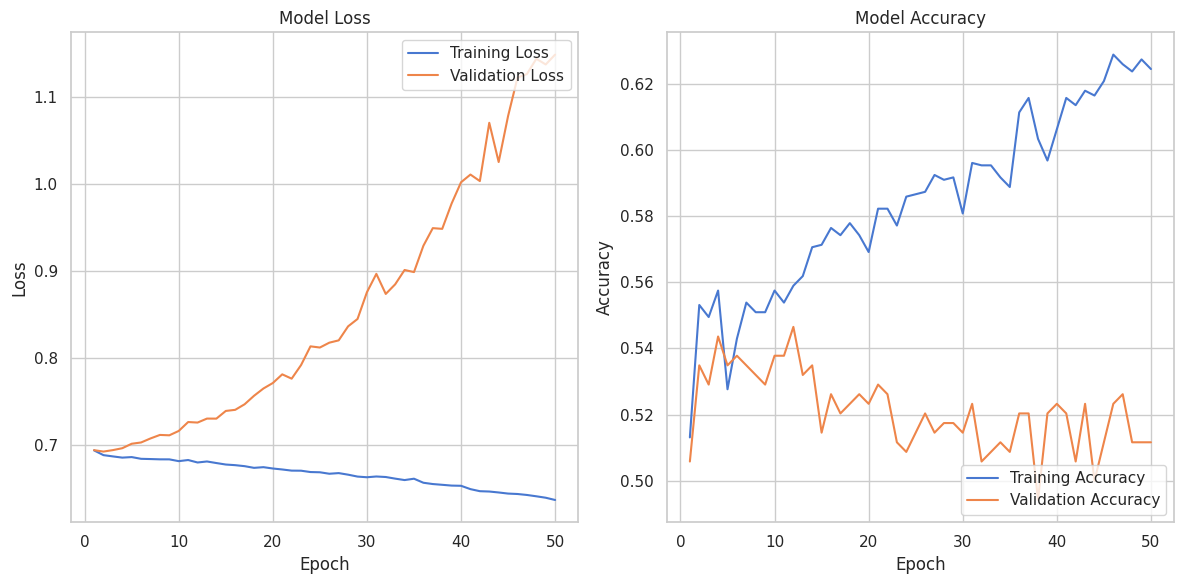

In [125]:
plot(history)

1/1 [==============================] - 1s 782ms/step


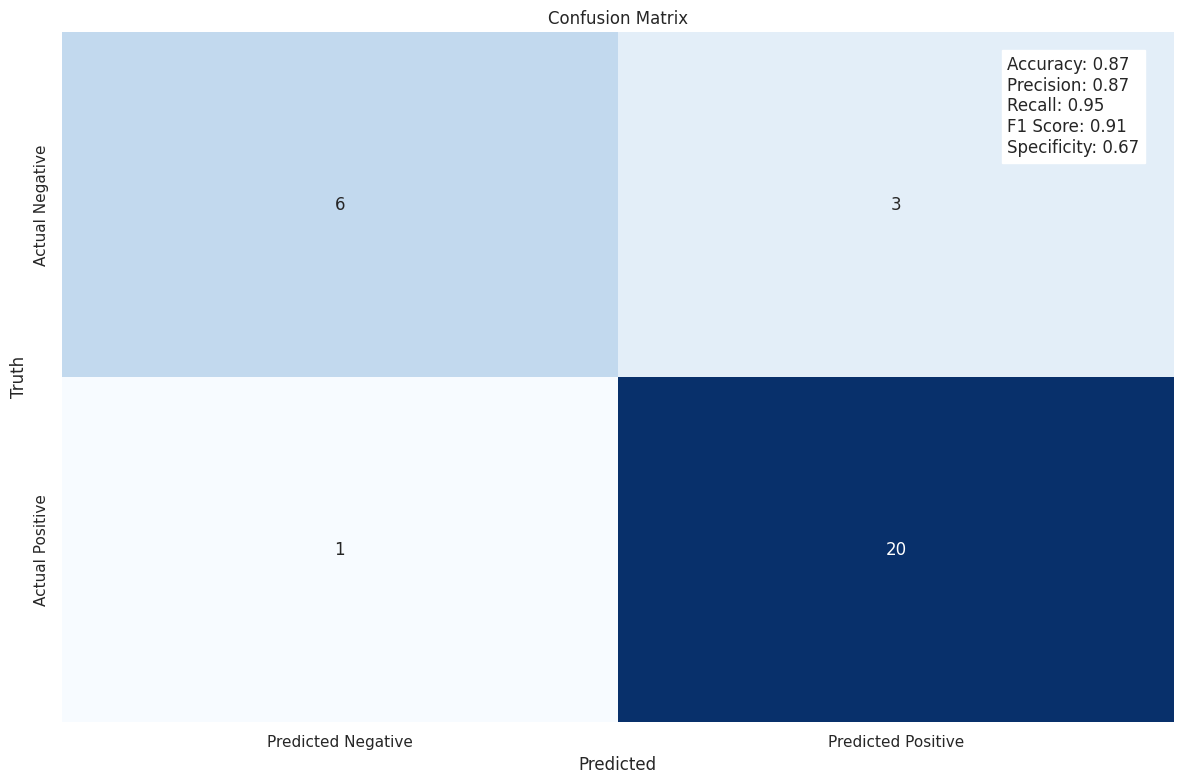

In [17]:
pred = lstm.predict(X_test, Y_test, threshold=0.5)['predictions']
error_matrix(Y_test, pred)

1/1 [==============================] - 0s 52ms/step


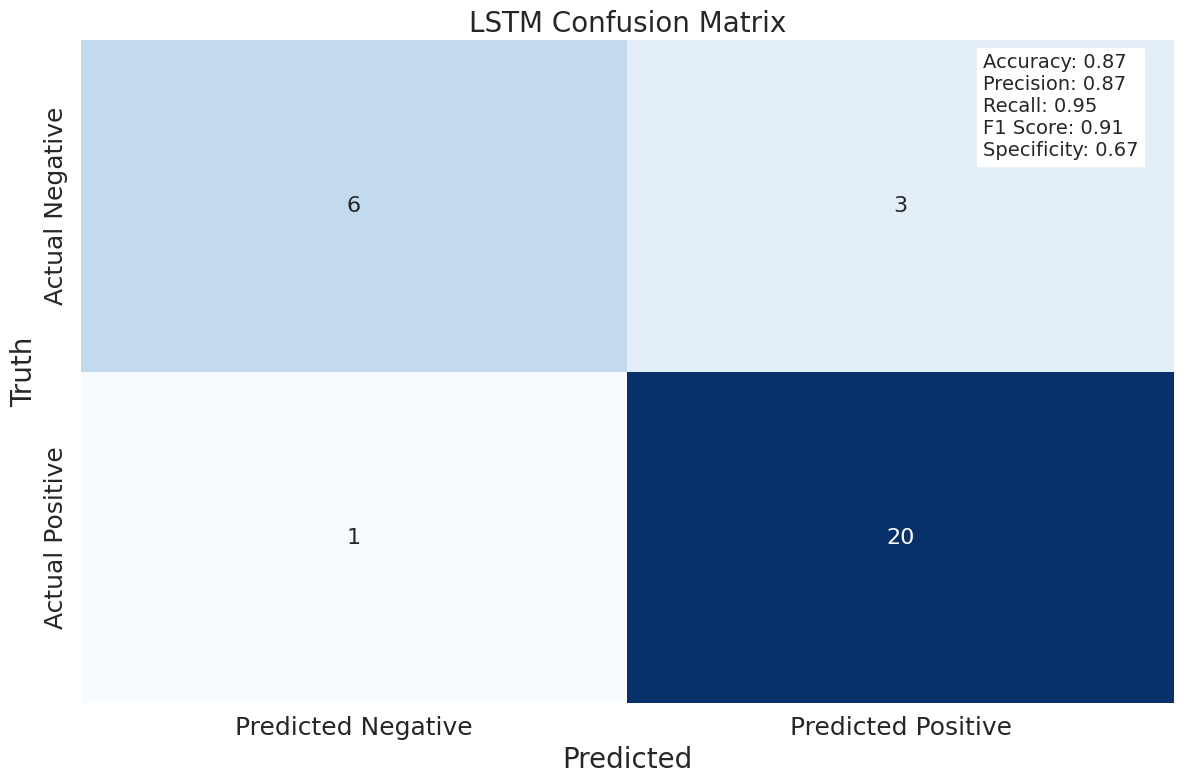

In [18]:
pred = lstm.predict(X_test, Y_test)['predictions']
conf_matrix = confusion_matrix(Y_test, pred)
errors = error_metrics(Y_test, pred)
accuracy = errors['accuracy']
precision = errors['precision']
recall = errors['recall']
f1 = errors['f1']
specificity = errors['specificity']


plt.figure(figsize=(12, 8))
heatmap=sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            annot_kws={"size": 16})

heatmap.set_xticklabels(heatmap.get_xticklabels(), size=18)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=18)

metrics_text = f'Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}\nSpecificity: {specificity:.2f}'
plt.text(1.65, 0.35, metrics_text, fontsize=14, bbox=dict(facecolor='white', alpha=1))

plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Truth', fontsize=20)
plt.title('LSTM Confusion Matrix', fontsize=20)

plt.tight_layout()
plt.savefig(path+"plots/project/"+"LSTM_confusion_dummy.pdf")
plt.show()

222/222 [==============================] - 1s 3ms/step


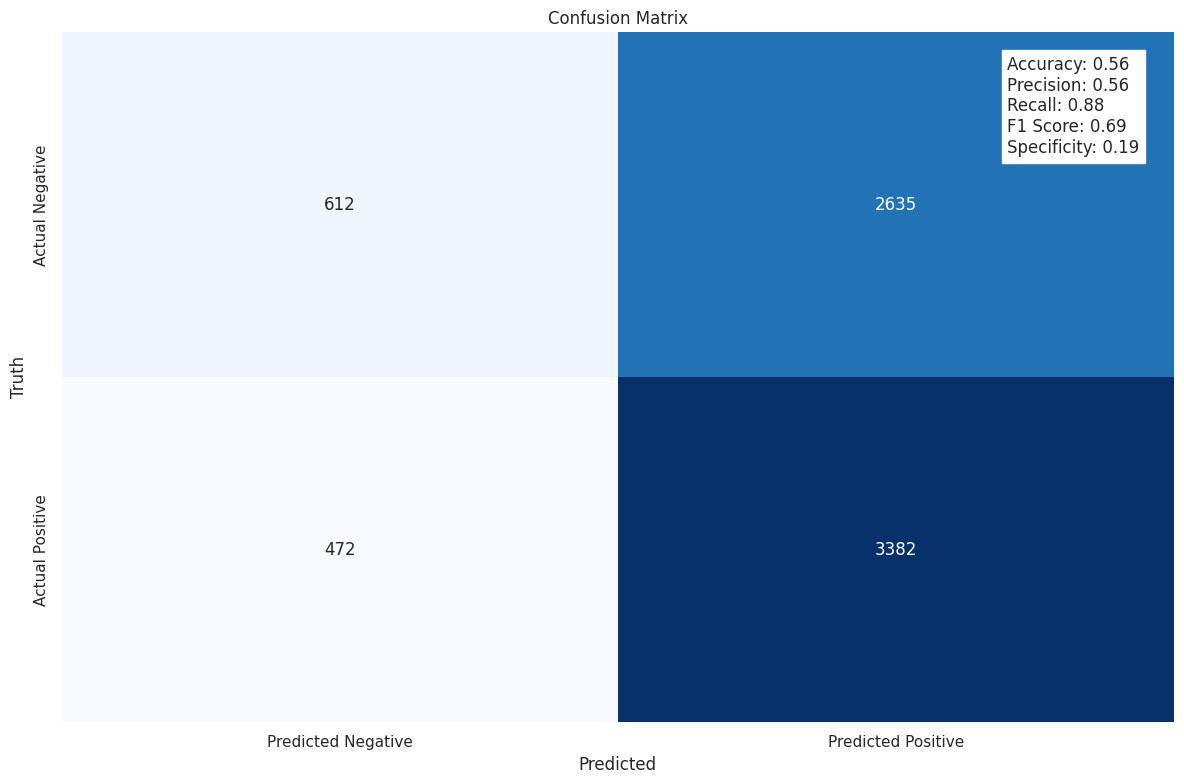

In [16]:
pred = lstm.predict(X_train, Y_train, threshold=0.5)['predictions']
error_matrix(Y_train, pred)

## RNN

In [ ]:
rnn_params = {
    'learning_rate': 0.01,
    'epochs': 20,
    'batch_size': 32,
    'lstm_units': 50,
    'dense_units': 64,
    'dropout_rate': 0.2,
    'optimizer': 'Adam',
    'wandb': False,
    'save': False,
    'name': 'RNN_MSFT_Binary_DUMMY',
    'run': 'run_01',
    'entity': 'asorliklab',
    'dataset': 'MSFT',
    'objective':'binary:logistic',
    'input_shape':input_shape,
    'test_split':30,
    'validation_split':0.2,
    'model_architecture':'RNN'
}

In [ ]:
rnn = Binary_RNN(capacity='low', **rnn_params)

In [ ]:
history = rnn.train(X_train, Y_train, X_val, Y_val)

Epoch 1/20
274/274 [==============================] - 4s 7ms/step - loss: 0.6130 - accuracy: 0.7352 - val_loss: 0.6022 - val_accuracy: 0.7570
Epoch 2/20
274/274 [==============================] - 1s 4ms/step - loss: 0.5795 - accuracy: 0.7593 - val_loss: 0.5625 - val_accuracy: 0.7614
Epoch 3/20
274/274 [==============================] - 1s 5ms/step - loss: 0.5118 - accuracy: 0.7764 - val_loss: 0.4999 - val_accuracy: 0.7484
Epoch 4/20
274/274 [==============================] - 1s 4ms/step - loss: 0.4509 - accuracy: 0.7758 - val_loss: 0.4689 - val_accuracy: 0.7354
Epoch 5/20
274/274 [==============================] - 1s 5ms/step - loss: 0.4283 - accuracy: 0.7806 - val_loss: 0.4769 - val_accuracy: 0.7440
Epoch 6/20
274/274 [==============================] - 1s 5ms/step - loss: 0.4282 - accuracy: 0.7744 - val_loss: 0.4642 - val_accuracy: 0.7440
Epoch 7/20
274/274 [==============================] - 1s 4ms/step - loss: 0.4249 - accuracy: 0.7812 - val_loss: 0.4715 - val_accuracy: 0.7419
Epoch 

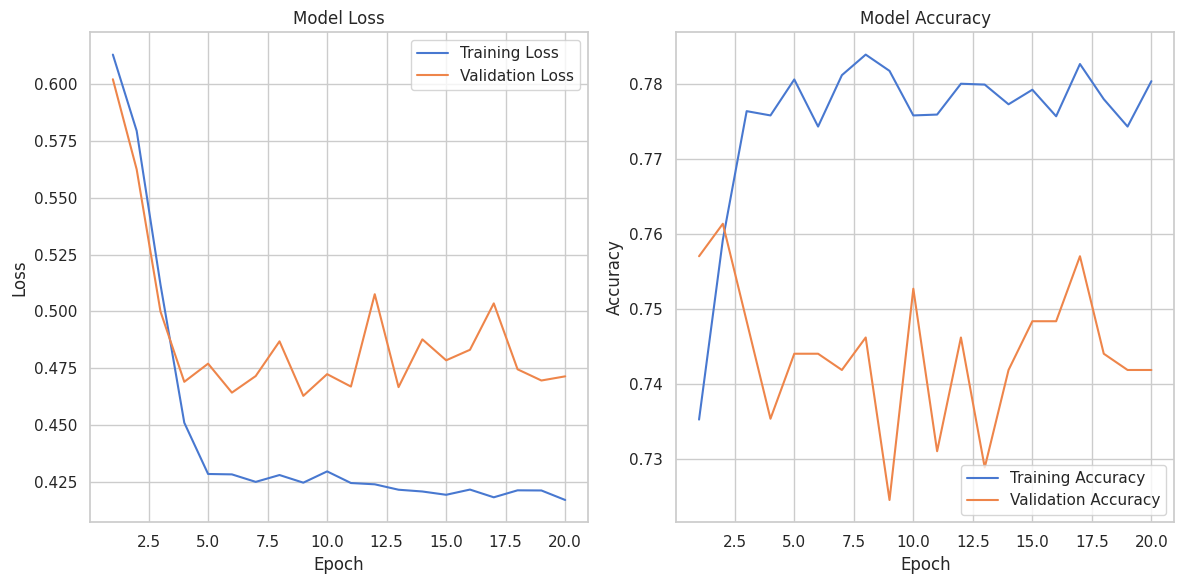

In [ ]:
plot(history)

2/2 [==============================] - 0s 8ms/step


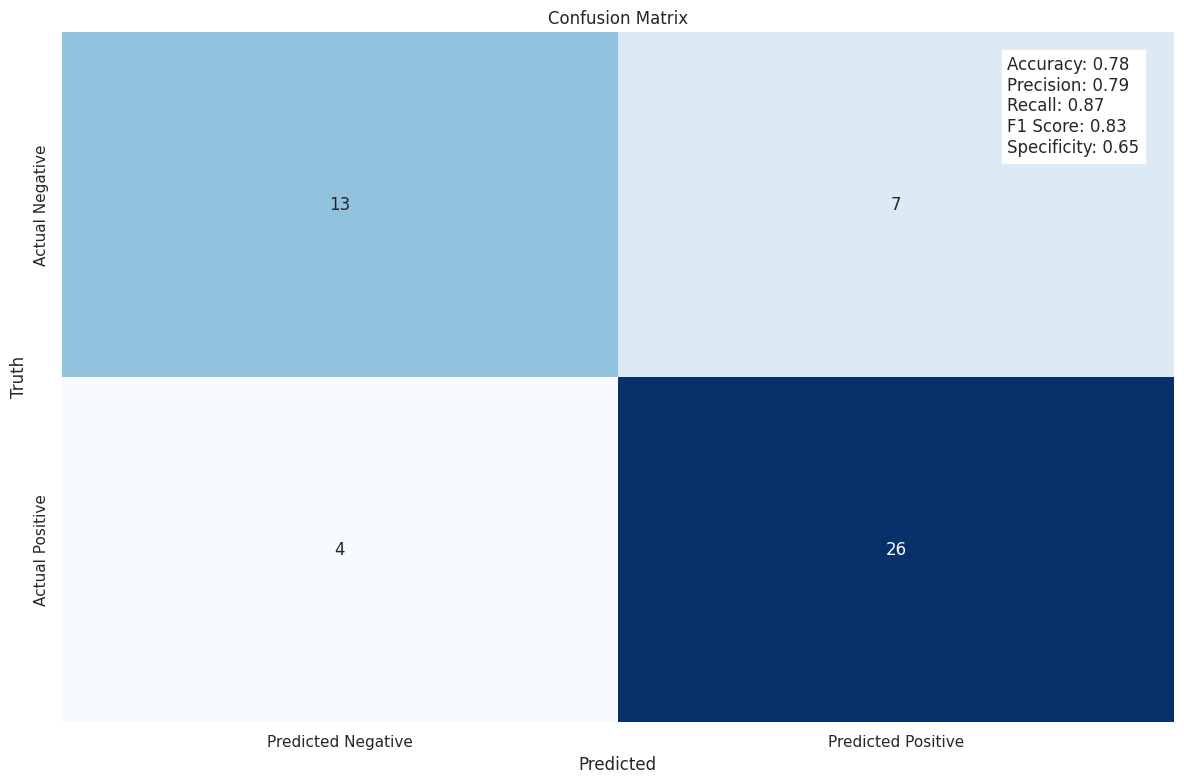

In [ ]:
pred = rnn.predict(X_test, Y_test, threshold=0.5)['predictions']
error_matrix(Y_test, pred)

## CNN

In [ ]:
cnn_params = {
    'learning_rate': 0.001,
    'epochs': 20,
    'batch_size': 32,
    'lstm_units': 50,
    'dense_units': 64,
    'dropout_rate': 0.2,
    'optimizer': 'Adam',
    'wandb': True,
    'save': False,
    'name': 'CNN_MSFT_Binary_DUMMY',
    'run': 'run_01',
    'entity': 'asorliklab',
    'dataset': 'MSFT',
    'objective':'binary:logistic',
    'input_shape':(10,25),
    'test_split':30,
    'validation_split':0.2,
    'model_architecture':'CNN'
}

In [ ]:
cnn = Binary_CNN(**cnn_params)

In [ ]:
history = cnn.train(X_train, Y_train, X_val, Y_val)

wandb: Currently logged in as: asorlik (asorliklab). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
265/273 [============================>.] - ETA: 0s - loss: 0.5115 - accuracy: 0.7316

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231129_000356-kc5kj2oj/files/model-best)... Done. 0.0s


273/273 [==============================] - 5s 14ms/step - loss: 0.5086 - accuracy: 0.7331 - val_loss: 0.4492 - val_accuracy: 0.7854
Epoch 2/20
267/273 [============================>.] - ETA: 0s - loss: 0.4554 - accuracy: 0.7608

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231129_000356-kc5kj2oj/files/model-best)... Done. 0.0s


273/273 [==============================] - 4s 16ms/step - loss: 0.4561 - accuracy: 0.7603 - val_loss: 0.4417 - val_accuracy: 0.7677
Epoch 3/20
273/273 [==============================] - 2s 7ms/step - loss: 0.4496 - accuracy: 0.7684 - val_loss: 0.4465 - val_accuracy: 0.7920
Epoch 4/20
273/273 [==============================] - 1s 5ms/step - loss: 0.4468 - accuracy: 0.7699 - val_loss: 0.4532 - val_accuracy: 0.7743
Epoch 5/20
273/273 [==============================] - 2s 6ms/step - loss: 0.4432 - accuracy: 0.7698 - val_loss: 0.4420 - val_accuracy: 0.7544
Epoch 6/20
263/273 [===========================>..] - ETA: 0s - loss: 0.4431 - accuracy: 0.7710

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231129_000356-kc5kj2oj/files/model-best)... Done. 0.0s


273/273 [==============================] - 2s 8ms/step - loss: 0.4411 - accuracy: 0.7722 - val_loss: 0.4347 - val_accuracy: 0.7588
Epoch 7/20
273/273 [==============================] - 1s 5ms/step - loss: 0.4390 - accuracy: 0.7753 - val_loss: 0.4376 - val_accuracy: 0.7633
Epoch 8/20
268/273 [============================>.] - ETA: 0s - loss: 0.4378 - accuracy: 0.7754

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231129_000356-kc5kj2oj/files/model-best)... Done. 0.0s


273/273 [==============================] - 2s 9ms/step - loss: 0.4376 - accuracy: 0.7752 - val_loss: 0.4269 - val_accuracy: 0.7765
Epoch 9/20
272/273 [============================>.] - ETA: 0s - loss: 0.4372 - accuracy: 0.7761

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231129_000356-kc5kj2oj/files/model-best)... Done. 0.0s


273/273 [==============================] - 7s 27ms/step - loss: 0.4367 - accuracy: 0.7765 - val_loss: 0.4231 - val_accuracy: 0.7898
Epoch 10/20
273/273 [==============================] - 3s 10ms/step - loss: 0.4373 - accuracy: 0.7723 - val_loss: 0.4257 - val_accuracy: 0.7655
Epoch 11/20
273/273 [==============================] - 1s 5ms/step - loss: 0.4350 - accuracy: 0.7773 - val_loss: 0.4339 - val_accuracy: 0.7655
Epoch 12/20
273/273 [==============================] - 1s 5ms/step - loss: 0.4349 - accuracy: 0.7777 - val_loss: 0.4321 - val_accuracy: 0.7588
Epoch 13/20
273/273 [==============================] - 1s 5ms/step - loss: 0.4313 - accuracy: 0.7796 - val_loss: 0.4261 - val_accuracy: 0.7854
Epoch 14/20
273/273 [==============================] - 1s 5ms/step - loss: 0.4321 - accuracy: 0.7766 - val_loss: 0.4346 - val_accuracy: 0.7633
Epoch 15/20
271/273 [============================>.] - ETA: 0s - loss: 0.4321 - accuracy: 0.7772

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231129_000356-kc5kj2oj/files/model-best)... Done. 0.0s


273/273 [==============================] - 3s 10ms/step - loss: 0.4318 - accuracy: 0.7773 - val_loss: 0.4230 - val_accuracy: 0.7677
Epoch 16/20
273/273 [==============================] - 3s 9ms/step - loss: 0.4305 - accuracy: 0.7799 - val_loss: 0.4364 - val_accuracy: 0.7544
Epoch 17/20
273/273 [==============================] - 2s 8ms/step - loss: 0.4292 - accuracy: 0.7781 - val_loss: 0.4332 - val_accuracy: 0.7765
Epoch 18/20
273/273 [==============================] - 2s 7ms/step - loss: 0.4303 - accuracy: 0.7837 - val_loss: 0.4310 - val_accuracy: 0.7677
Epoch 19/20
267/273 [============================>.] - ETA: 0s - loss: 0.4299 - accuracy: 0.7842

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231129_000356-kc5kj2oj/files/model-best)... Done. 0.0s


273/273 [==============================] - 3s 11ms/step - loss: 0.4307 - accuracy: 0.7825 - val_loss: 0.4212 - val_accuracy: 0.7832
Epoch 20/20
273/273 [==============================] - 2s 6ms/step - loss: 0.4285 - accuracy: 0.7809 - val_loss: 0.4257 - val_accuracy: 0.7898


accuracy,▁▅▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▇▃█▅▁▂▃▅█▃▃▂▇▃▃▁▅▃▆█
val_loss,▇▅▇█▆▄▅▂▁▂▄▃▂▄▁▄▄▃▁▂
accuracy,0.78088
best_epoch,18
best_val_loss,0.42124
epoch,19
loss,0.42851
val_accuracy,0.78982


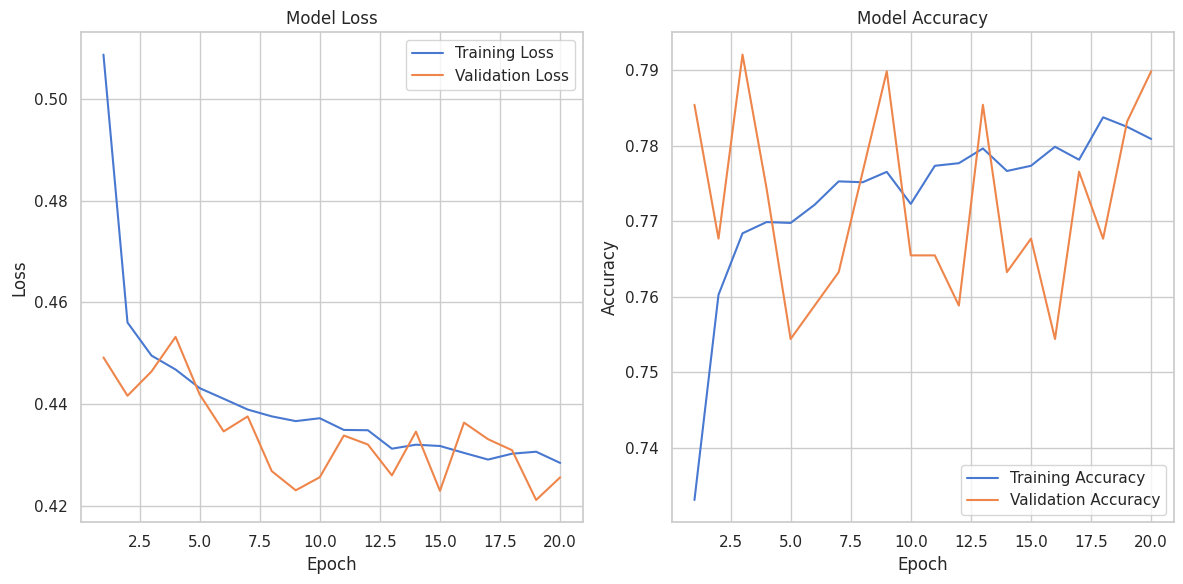

In [ ]:
plot(history)

2/2 [==============================] - 0s 7ms/step


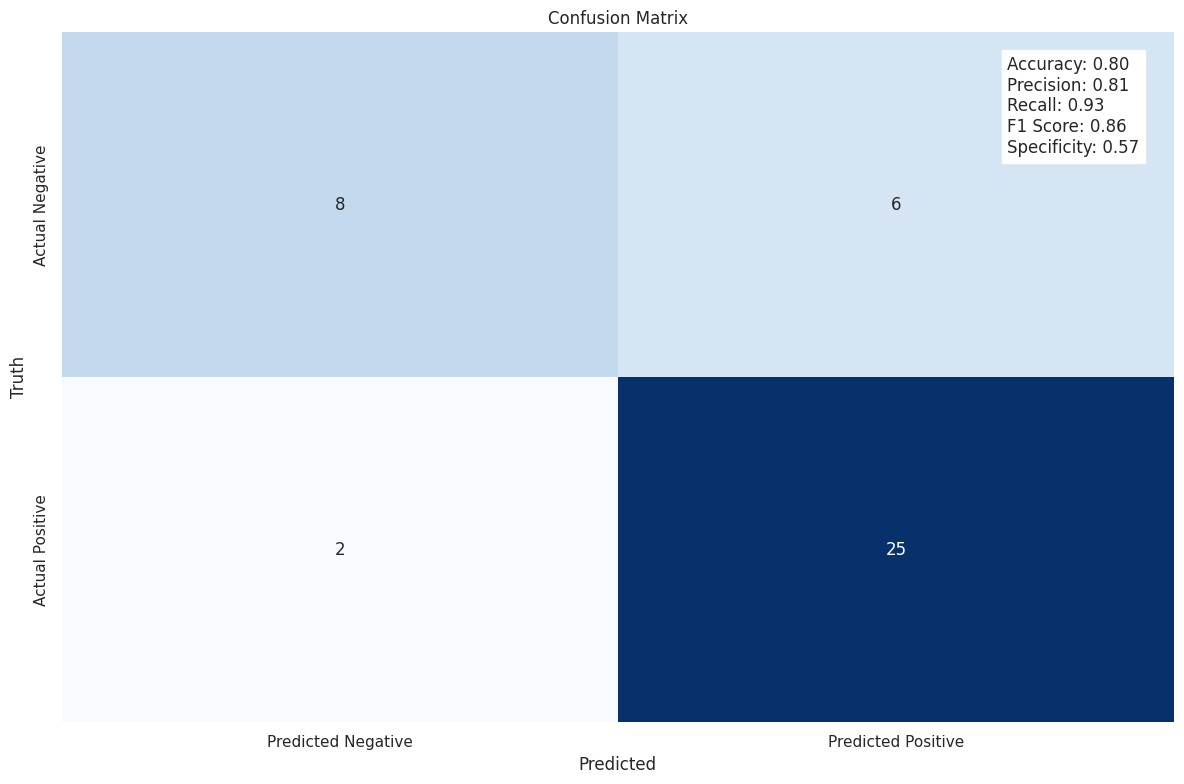

In [ ]:
pred = cnn.predict(X_test, Y_test, threshold=0.5)['predictions']
Xt, Yt = transform_features_CNN_overlapping(X_test, Y_test)
error_matrix(Yt, pred)

In [ ]:
pred